### Packages and Visualization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator and Noise 

In [3]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
        
    def forward(self, noise):
        
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Classifier

In [4]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)


### Specifying Parameters

In [5]:
z_dim = 64
batch_size = 128
device = 'cuda'

### Loading the Pretrained Models

In [6]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


#### Update Noise

For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by new = old + (∇ old * weight), where ∇ is the gradient of old. You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

In [7]:
# Returning the new noise with the gradient already calculated with the new classifier
def calculate_updated_noise(noise, weight):
    
    new_noise = noise + (noise.grad * weight)
    
    return new_noise

In [8]:
# UNIT TEST
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [9]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

Success!


### Generation

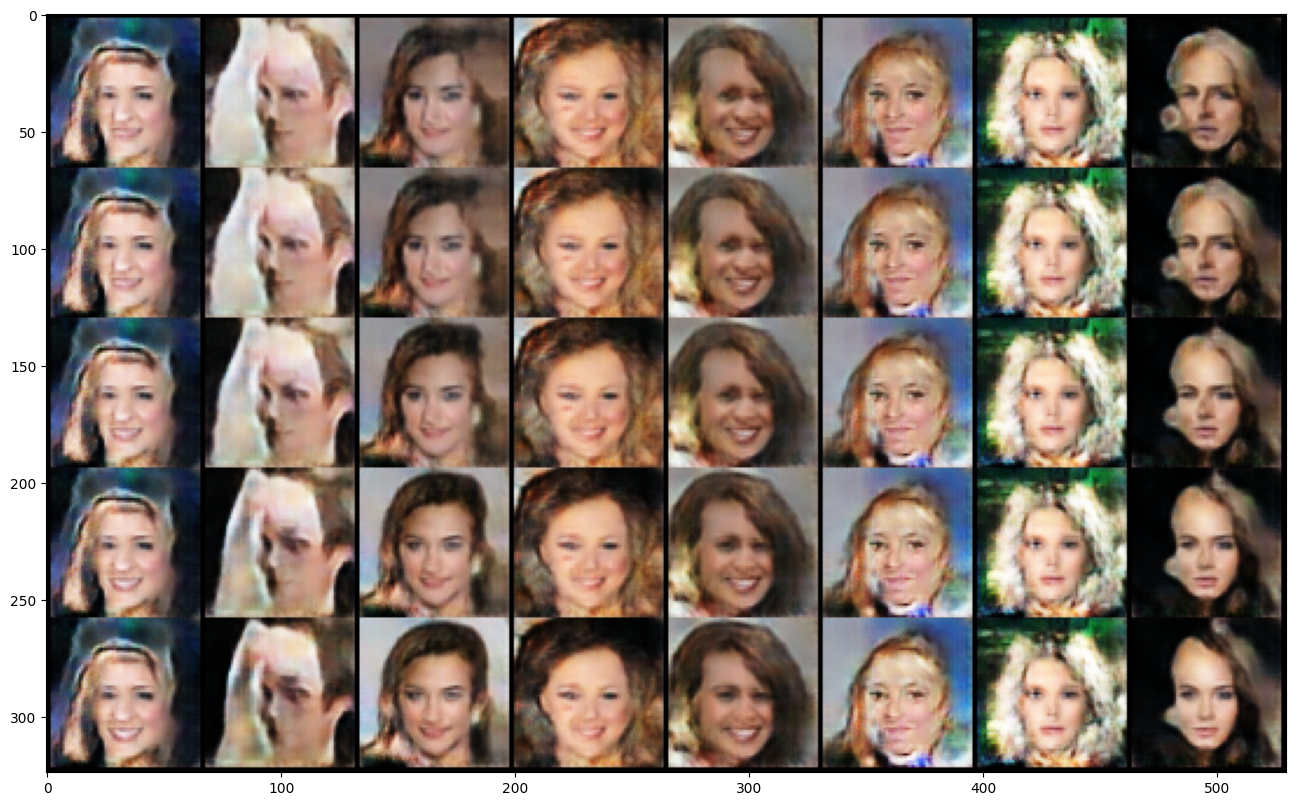

In [20]:
# First generating a bunch of images using the generator
n_images = 8
fake_image_history = []
grad_steps = 10
skip = 2 

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Young")

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)
    
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

### Entanglement and Regularization

        We can see that by changing the noise above, some other factors other than that in question also emerged and changed this means that some of the features in our generated noise are entangled, which means that on changing one changes other other. So, to fix this what we can do is that, we can isolate the target feature more by holding the classes outside the target class as constant. For every non target class, take the difference between old and new noise. The greater the value is, the more features outside the target class have changed. What will we do is that we will calculate the magnitude of change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise

In [25]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    
    other_distances = current_classifications[:, other_indices] - original_classifications[:, other_indices]
    
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    
    target_score = current_classifications[:, target_indices].mean()
    
    return target_score + other_class_penalty

In [26]:
# UNIT TEST
assert torch.isclose(
    get_score(torch.ones(4, 3), torch.zeros(4, 3), [0], [1, 2], 0.2), 
    1 - torch.sqrt(torch.tensor(2.)) * 0.2
)
print("Success!")

Success!


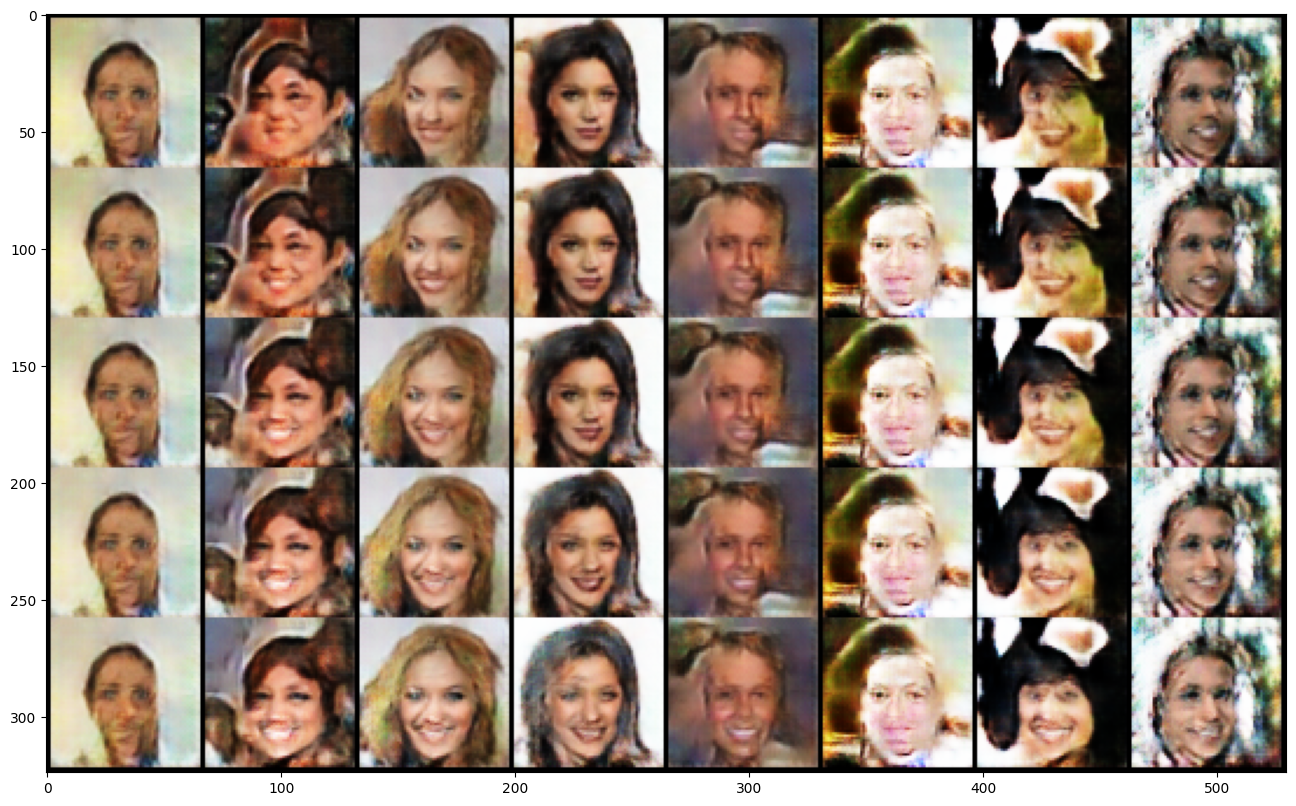

In [30]:
fake_image_history = []

target_indices = feature_names.index("Smiling")
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()

for i in range(grad_steps):
    
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake),
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)
    
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)